In [2]:
import os
import sys
import subprocess
import time
import logging
import json
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import cv2
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Define your dataset and extraction folder (adjust the paths as needed)
DATASET_ROOT = Path("C:/Users/abhis/Downloads/Documents/Learner Engagement Project/data/DAiSEE/DataSet").resolve()
FRAMES_ROOT  = Path("C:/Users/abhis/Downloads/Documents/Learner Engagement Project/data/DAiSEE/ExtractedFrames").resolve()

# Validate that the dataset contains the required splits.
def validate_dataset(directory: Path):
    required_folders = ["Train", "Validation", "Test"]
    for folder in required_folders:
        folder_path = directory / folder
        if not folder_path.exists():
            raise FileNotFoundError(f"Missing dataset split: {folder_path}")
    print(f"✅ Dataset validated at {directory}")

validate_dataset(DATASET_ROOT)

✅ Dataset validated at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\DataSet


## **Verify Label–Frame Alignment**

**Verify Label–Frame Alignment**: This cell verifies that every label in your CSV file has a corresponding extracted frame. It scans each row in the CSV (e.g., _TrainLabels.csv_) and computes the expected frame path. If the frame file does not exist, it logs a warning. Use this cell after dataset validation to ensure your labels and frames are aligned.


In [3]:
# Cell: Verify Label–Frame Alignment
import pandas as pd
from pathlib import Path
import logging

logger = logging.getLogger(__name__)

def verify_label_frame_alignment(csv_path, frames_root):
    """
    Verifies that every label in the CSV has a corresponding frame file.
    Returns a list of row indices for which the frame is missing.
    """
    df = pd.read_csv(csv_path)
    missing_indices = []
    
    for idx, row in df.iterrows():
        clip_id = str(row['ClipID']).strip()
        # Remove .avi extension if present
        if '.avi' in clip_id:
            clip_id = clip_id.replace('.avi', '')
        parts = clip_id.split('/')
        
        # If the ClipID has only one part, infer the split from the CSV name.
        if len(parts) == 1:
            split_guess = Path(csv_path).stem.replace("Labels", "").strip()
            frame_path = Path(frames_root) / split_guess / parts[0] / "frame_0001.jpg"
        elif len(parts) == 2:
            frame_path = Path(frames_root) / parts[0] / parts[1] / "frame_0001.jpg"
        elif len(parts) >= 3:
            frame_path = Path(frames_root) / parts[0] / parts[1] / parts[2] / "frame_0001.jpg"
        else:
            logger.warning(f"Row {idx}: Unexpected ClipID format: {clip_id}")
            missing_indices.append(idx)
            continue
        
        if not frame_path.exists():
            logger.warning(f"Missing frame for row {idx}: {frame_path}")
            missing_indices.append(idx)
    
    if missing_indices:
        logger.info(f"Found {len(missing_indices)} rows with missing frames.")
    else:
        logger.info("All labels have corresponding frames.")
    return missing_indices

csv_train = DATASET_ROOT / "Labels" / "TrainLabels.csv"
missing_train = verify_label_frame_alignment(csv_train, FRAMES_ROOT)


Missing frame for row 1411: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\ExtractedFrames\Train\2026140111.mp4\frame_0001.jpg
Missing frame for row 1412: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\ExtractedFrames\Train\2026140113.mp4\frame_0001.jpg
Missing frame for row 1413: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\ExtractedFrames\Train\2026140116.mp4\frame_0001.jpg
Missing frame for row 1414: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\ExtractedFrames\Train\2026140117.mp4\frame_0001.jpg
Missing frame for row 1415: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\ExtractedFrames\Train\2026140118.mp4\frame_0001.jpg
Missing frame for row 1416: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\ExtractedFrames\Train\2026140119.mp4\frame_0001.jpg
Missing frame for row 1417: C:\Users\abhis\Downloads\Documents\Learner Engag

### **Extract Frames from Videos**

Convert video files into individual frames for model training. This step is necessary as the DAiSEE dataset contains video clips, and models require image frames.


In [4]:
# Persistent storage file to remember which videos have been processed.
PROCESSED_VIDEOS_FILE = FRAMES_ROOT / "processed_videos.json"

def load_processed_videos():
    if PROCESSED_VIDEOS_FILE.exists():
        with open(PROCESSED_VIDEOS_FILE, "r") as f:
            processed = json.load(f)
    else:
        processed = {}  # e.g., {"Train": ["1100011015", ...], "Validation": [...], "Test": [...]}
    return processed

def save_processed_video(split, video_stem):
    processed = load_processed_videos()
    if split not in processed:
        processed[split] = []
    if video_stem not in processed[split]:
        processed[split].append(video_stem)
    with open(PROCESSED_VIDEOS_FILE, "w") as f:
        json.dump(processed, f)

# Configure logging to both console and file.
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('frame_extraction.log')
    ]
)
logger = logging.getLogger(__name__)

# Extraction parameters and resume settings
TARGET_FRAMES = 15
TARGET_RESOLUTION = (224, 224)
# If True, consider a video processed even if its folder has at least PARTIAL_THRESHOLD frames.
RESUME_ON_PARTIAL = True  
PARTIAL_THRESHOLD = 1  

# Build a dictionary of already existing output directories.
def get_existing_output_dirs(output_root: Path):
    processed = {}
    for split in ["Train", "Validation", "Test"]:
        split_dir = output_root / split
        if split_dir.exists():
            for video_dir in split_dir.iterdir():
                if video_dir.is_dir():
                    processed[(split, video_dir.name)] = video_dir
    return processed

# Scan the extraction folder and log how many videos are fully processed.
def verify_extracted_frames():
    processed_dirs = get_existing_output_dirs(FRAMES_ROOT)
    total_videos = 0
    fully_processed = 0
    for key, video_dir in processed_dirs.items():
        frames = list(video_dir.rglob("frame_*.jpg"))
        if frames:
            total_videos += 1
            if len(frames) >= TARGET_FRAMES:
                fully_processed += 1
    logger.info(f"Verification complete: {fully_processed}/{total_videos} videos fully processed")
    return fully_processed, total_videos

# Check for FFmpeg installation and CUDA support.
def check_ffmpeg():
    try:
        subprocess.run(['ffmpeg', '-version'], capture_output=True, text=True, check=True)
        cuda = subprocess.run(['ffmpeg', '-hwaccels'], capture_output=True, text=True, check=True)
        has_cuda = 'cuda' in cuda.stdout.lower()
        return True, has_cuda
    except (FileNotFoundError, subprocess.CalledProcessError):
        return False, False

# Compare dataset .avi files against the persistent record and output folder.
def get_unprocessed_videos(dataset_root: Path, output_root: Path):
    videos_to_process = []
    total_videos = 0
    already_processed_count = 0
    processed_dirs = get_existing_output_dirs(output_root)
    persistent = load_processed_videos()

    logger.info(f"Scanning dataset in: {dataset_root}")
    logger.info(f"Using extracted frames from: {output_root}")

    for video_path in dataset_root.rglob("*.avi"):
        total_videos += 1
        rel = video_path.relative_to(dataset_root)  # e.g., "Train/1100011015.avi"
        split = rel.parts[0]
        video_stem = video_path.stem

        # Check the persistent record first.
        if split in persistent and video_stem in persistent[split]:
            output_dir = output_root / split / video_stem
            if output_dir.exists():
                frames = list(output_dir.rglob("frame_*.jpg"))
                if len(frames) >= PARTIAL_THRESHOLD:
                    already_processed_count += 1
                    continue

        # Next, if the folder exists, use its frame count.
        output_dir = output_root / split / video_stem
        if output_dir.exists():
            frames = list(output_dir.rglob("frame_*.jpg"))
            if RESUME_ON_PARTIAL and len(frames) >= PARTIAL_THRESHOLD:
                already_processed_count += 1
                save_processed_video(split, video_stem)
                continue
            elif len(frames) >= TARGET_FRAMES:
                already_processed_count += 1
                save_processed_video(split, video_stem)
                continue
            else:
                # Remove incomplete frames.
                for frame in frames:
                    frame.unlink()

        videos_to_process.append((video_path, output_dir))
    
    logger.info("\nScan Results:")
    logger.info(f"Total .avi files found: {total_videos}")
    logger.info(f"Already processed (or partially processed): {already_processed_count}")
    logger.info(f"Remaining to process: {len(videos_to_process)}")
    return videos_to_process

# Extract frames from a single video using FFmpeg (with a fallback from GPU to CPU).
def extract_frames_with_ffmpeg(video_path, output_folder, use_gpu=True):
    try:
        output_folder = Path(output_folder)
        output_folder.mkdir(parents=True, exist_ok=True)

        # Get the video duration via ffprobe.
        duration_cmd = [
            'ffprobe', '-v', 'error',
            '-select_streams', 'v:0',
            '-show_entries', 'stream=duration',
            '-of', 'default=noprint_wrappers=1:nokey=1',
            str(video_path)
        ]
        duration_output = subprocess.check_output(duration_cmd, stderr=subprocess.STDOUT)
        duration = float(duration_output.decode().strip())
        frame_interval = max(1, duration / TARGET_FRAMES)

        cmd = ['ffmpeg', '-y']
        if use_gpu:
            cmd.extend([
                '-hwaccel', 'cuda',
                '-hwaccel_output_format', 'cuda',
                '-c:v', 'h264_cuvid'
            ])
        
        cmd.extend([
            '-i', str(video_path),
            '-vf', f'fps=1/{frame_interval},scale={TARGET_RESOLUTION[0]}:{TARGET_RESOLUTION[1]}',
            '-frame_pts', '1',
            '-vsync', '0',
            '-preset', 'ultrafast',
            '-q:v', '2',
            str(output_folder / 'frame_%04d.jpg')
        ])

        result = subprocess.run(cmd, capture_output=True, text=True)
        if result.returncode != 0:
            if use_gpu:
                # Retry with CPU if GPU fails.
                return extract_frames_with_ffmpeg(video_path, output_folder, use_gpu=False)
            raise subprocess.CalledProcessError(result.returncode, cmd, result.stderr)

        extracted_frames = list(output_folder.rglob("frame_*.jpg"))
        if not RESUME_ON_PARTIAL and len(extracted_frames) < TARGET_FRAMES:
            raise ValueError(f"Expected {TARGET_FRAMES} frames, got {len(extracted_frames)}")
        
        # Mark the video as processed.
        rel = video_path.relative_to(DATASET_ROOT)
        split = rel.parts[0]
        video_stem = video_path.stem
        save_processed_video(split, video_stem)

        return True, None

    except Exception as e:
        return False, str(e)

# Process all unprocessed videos using parallel workers.
def process_dataset(dataset_root: Path, output_root: Path, max_workers=None):
    if max_workers is None:
        max_workers = min(32, (os.cpu_count() or 1) + 4)
    
    video_paths = get_unprocessed_videos(dataset_root, output_root)
    if not video_paths:
        logger.info("No videos to process!")
        return 0, 0

    ffmpeg_available, cuda_available = check_ffmpeg()
    if not ffmpeg_available:
        raise RuntimeError("FFmpeg not found or not in PATH.")
    
    logger.info(f"Starting processing with {max_workers} workers (CUDA: {cuda_available})")
    failed_videos = []
    start_time = time.time()

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(
                extract_frames_with_ffmpeg,
                str(vp[0]),  # video_path
                str(vp[1]),  # output_folder
                cuda_available
            ): vp[0] for vp in video_paths
        }
        with tqdm(total=len(video_paths), desc="Extracting frames") as pbar:
            for future in as_completed(futures):
                video_path = futures[future]
                try:
                    success, error = future.result()
                    if not success:
                        failed_videos.append((video_path, error))
                except Exception as e:
                    failed_videos.append((video_path, str(e)))
                pbar.update(1)

    elapsed_time = time.time() - start_time
    success_count = len(video_paths) - len(failed_videos)
    logger.info(f"\nProcessing completed in {elapsed_time:.2f} seconds")
    logger.info(f"Successfully processed: {success_count}/{len(video_paths)} videos")
    if failed_videos:
        logger.error(f"\nFailed to process {len(failed_videos)} videos:")
        for video, error in failed_videos[:10]:
            logger.error(f"- {video.name}: {error}")
        if len(failed_videos) > 10:
            logger.error(f"... and {len(failed_videos) - 10} more")
    return success_count, len(failed_videos)

### **Process Entire Dataset**


In [25]:
if __name__ == "__main__":
    try:
        logger.info("Starting frame extraction process...")
        processed, total = verify_extracted_frames()
        logger.info(f"Found {processed} already processed video(s) out of {total} in the extracted frames folder.")
        
        # Run the extraction process.
        success, failures = process_dataset(DATASET_ROOT, FRAMES_ROOT)
        if failures:
            logger.error(f"Processing encountered errors with {failures} videos.")
        else:
            logger.info("All videos processed successfully!")
        
        # Best Practice:
        # For long-running tasks, consider running this script as a scheduled task or as a background service 
        # (for example, via a cron job, Windows Task Scheduler, or nohup) so that it can run uninterrupted.
        
        sys.exit(0 if failures == 0 else 1)
    except Exception as e:
        logger.error(f"Fatal error: {str(e)}")
        sys.exit(1)


2025-02-09 18:24:26,847 - INFO - Starting frame extraction process...
2025-02-09 18:24:29,375 - INFO - Verification complete: 0/8231 videos fully processed
2025-02-09 18:24:29,379 - INFO - Found 0 already processed video(s) out of 8231 in the extracted frames folder.
2025-02-09 18:24:29,703 - INFO - Scanning dataset in: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\DataSet
2025-02-09 18:24:29,704 - INFO - Using extracted frames from: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\ExtractedFrames
2025-02-09 18:26:15,294 - INFO - 
Scan Results:
2025-02-09 18:26:15,294 - INFO - Total .avi files found: 8231
2025-02-09 18:26:15,295 - INFO - Already processed (or partially processed): 8231
2025-02-09 18:26:15,295 - INFO - Remaining to process: 0
2025-02-09 18:26:15,299 - INFO - No videos to process!
2025-02-09 18:26:15,300 - INFO - All videos processed successfully!


SystemExit: 0

c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\IPython\core\interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## **Implement Resume Extraction**

**Implement Resume Extraction:** Instead of deleting partially processed frames, this cell implements a function that checks a video’s output folder and returns the next frame index that needs to be extracted. This allows your extraction script to resume from where it left off rather than starting over.


In [5]:
# Resume Extraction Function
from pathlib import Path
import logging

def resume_extraction_for_video(video_id, split, frames_root, target_frames=15):
    """
    Checks the output folder for a given video and returns the next frame index to extract.
    If the folder doesn't exist, returns 0.
    If some frames exist, returns the count of existing frames.
    
    Parameters:
      - video_id: Unique identifier for the video (e.g., "1100011015").
      - split: The dataset split as a string (e.g., "Train", "Validation", or "Test").
      - frames_root: The root folder where frames are stored.
      - target_frames: The expected number of frames per video.
    
    Returns:
      - The next frame index to be extracted.
    """
    output_folder = Path(frames_root) / split / str(video_id)
    if not output_folder.exists():
        logging.info(f"No folder found for video {video_id} in split {split}. Starting from frame 0.")
        return 0
    existing_frames = list(output_folder.glob("frame_*.jpg"))
    count = len(existing_frames)
    if count < target_frames:
        logging.info(f"Video {video_id} in split {split}: {count} frames found; resuming extraction from frame index {count}.")
    else:
        logging.info(f"Video {video_id} in split {split} already fully processed.")
    return count

# Example usage:
video_id_example = "1100011015"  # Replace with an actual video ID from your dataset
split_example = "Train"          # Adjust based on your CSV or context
next_frame_index = resume_extraction_for_video(video_id_example, split_example, FRAMES_ROOT)
logging.info(f"Next frame index for video {video_id_example} in split {split_example}: {next_frame_index}")


2025-02-09 19:08:15,347 - INFO - Video 1100011015 in split Train: 10 frames found; resuming extraction from frame index 10.
2025-02-09 19:08:15,348 - INFO - Next frame index for video 1100011015 in split Train: 10


### **Data Transforms**

Define transformations for training (with data augmentation) and validation/testing (without augmentation).


In [6]:
from torchvision import transforms

# Preprocessing transformations for training and validation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])


### **Custom Dataset Class**

Create a custom dataset loader to read image paths and labels from text files.


In [7]:
import os
import torch
from torch.utils.data import Dataset
import pandas as pd
from pathlib import Path
from PIL import Image
import logging
from tqdm import tqdm
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image

# Ensure the logger shows DEBUG messages
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

class DAiSEEDataset(Dataset):
    """
    Updated dataset class for DAiSEE that reads a CSV with four engagement metrics.
    It precomputes the frame paths based on the ClipID and loads labels for 
    Boredom, Engagement, Confusion, and Frustration.
    
    If the ClipID does not contain a slash (i.e. it's just a number), the split is
    inferred from the CSV file name. For example, for TrainLabels.csv, we assume the split is "Train".
    """
    def __init__(self, root, csv_path, transform=None, use_cache=True):
        self.root = Path(root)
        self.transform = transform
        self.use_cache = use_cache
        
        # Read the CSV file
        self.data = pd.read_csv(csv_path)
        
        # Pre-compute frame paths and labels with a progress bar
        self.frame_paths = []
        self.labels = []
        
        logger.info(f"Processing {len(self.data)} entries from {csv_path.name}")
        for idx, row in tqdm(self.data.iterrows(), total=len(self.data), desc="Loading dataset"):
            try:
                clip_id = str(row['ClipID']).strip()
                # Remove the .avi extension if present
                if '.avi' in clip_id:
                    clip_id = clip_id.replace('.avi', '')
                parts = clip_id.split('/')
                
                # Determine the frame path based on the number of parts:
                if len(parts) == 1:
                    # If only one part exists, infer the split from the CSV filename.
                    # For example, if csv_path is TrainLabels.csv, we deduce split = "Train".
                    split_guess = csv_path.stem.replace("Labels", "").strip()
                    frame_path = self.root / split_guess / parts[0] / "frame_0001.jpg"
                elif len(parts) == 2:
                    frame_path = self.root / parts[0] / parts[1] / "frame_0001.jpg"
                elif len(parts) >= 3:
                    frame_path = self.root / parts[0] / parts[1] / parts[2] / "frame_0001.jpg"
                else:
                    logger.debug(f"Skipping row {idx}: unexpected ClipID format: {clip_id}")
                    continue  # Skip rows that do not match the expected pattern

                # Log the computed frame path
                if not frame_path.exists():
                    logger.debug(f"Frame path does not exist: {frame_path}")
                else:
                    logger.debug(f"Found frame: {frame_path}")
                
                if frame_path.exists():
                    self.frame_paths.append(frame_path)
                    self.labels.append([
                        float(row['Boredom']),
                        float(row['Engagement']),
                        float(row['Confusion']),
                        float(str(row['Frustration ']).strip())
                    ])
            except Exception as e:
                logger.debug(f"Skipping row {idx} due to error: {e}")
                continue
        
        logger.info(f"Loaded {len(self.frame_paths)} valid frames")
        
        if len(self.frame_paths) == 0:
            raise ValueError(f"No valid frames found in {csv_path}")
    
    def __len__(self):
        return len(self.frame_paths)
    
    def __getitem__(self, idx):
        img_path = self.frame_paths[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        # Use torchvision.io.read_image which returns a tensor of shape [C, H, W]
        img_tensor = read_image(img_path)
        # Optionally convert the tensor to a PIL image if your transform chain requires it
        if self.transform:
            img = self.transform(to_pil_image(img_tensor))
        else:
            img = img_tensor
        return img, label


## **Cache Extracted Data for Faster Reloads**

**Cache Datasets Using joblib:** To avoid reloading and reprocessing the CSV and dataset objects on every execution, this cell caches the dataset objects to a pickle file using joblib. On subsequent runs, the datasets are loaded directly from the cache, greatly reducing startup time. Insert this cell immediately before your DataLoader creation cell.


In [ ]:
# Cache Datasets Using joblib
import joblib
from pathlib import Path

cache_file = "cached_datasets.pkl"

if Path(cache_file).exists():
    logger.info("Loading cached datasets...")
    datasets = joblib.load(cache_file)
else:
    logger.info("Creating datasets and caching them...")
    datasets = {}
    for split_name, transform, csv_name in [
        ("Train", train_transform, "TrainLabels.csv"),
        ("Validation", valid_transform, "ValidationLabels.csv"),
        ("Test", valid_transform, "TestLabels.csv")
    ]:
        csv_path = DATASET_ROOT / "Labels" / csv_name
        datasets[split_name] = DAiSEEDataset(
            root=FRAMES_ROOT,
            csv_path=csv_path,
            transform=transform
        )
    joblib.dump(datasets, cache_file)
    logger.info("Datasets cached successfully.")


2025-02-09 19:08:30,402 - INFO - Loading cached datasets...


### Implement Caching & Resume Logic for Faster Reloads

This cell caches preprocessed metadata (e.g., which videos have already been processed and the number of frames extracted) so that if you restart the script, you do not have to reprocess everything from scratch.

The metadata is saved to a file (using joblib) and loaded on subsequent runs. This can greatly speed up reloading if nothing has changed.

Below is the code for caching and resuming metadata.


In [9]:
import joblib
from pathlib import Path

# Define the filename for the metadata cache.
metadata_cache_file = "metadata_cache.pkl"

def load_metadata_cache():
    """
    Load the metadata cache if it exists; otherwise, return an empty dictionary.
    """
    cache_path = Path(metadata_cache_file)
    if cache_path.exists():
        logger.info("Loading metadata cache...")
        return joblib.load(cache_path)
    else:
        logger.info("No metadata cache found. Starting fresh.")
        return {}

def save_metadata_cache(metadata):
    """
    Save the metadata cache to disk.
    """
    joblib.dump(metadata, metadata_cache_file)
    logger.info("Metadata cache saved.")

# Load or create the metadata cache.
metadata = load_metadata_cache()

# Check if the cache contains information about processed videos.
if "processed_videos" not in metadata:
    logger.info("Building metadata for processed videos...")
    metadata["processed_videos"] = {}
    
    # Loop over all .avi files in the dataset to store the number of extracted frames.
    for video_path in DATASET_ROOT.rglob("*.avi"):
        rel = video_path.relative_to(DATASET_ROOT)
        split = rel.parts[0]  # e.g., 'Train'
        video_stem = video_path.stem
        output_folder = FRAMES_ROOT / split / video_stem
        if output_folder.exists():
            frame_count = len(list(output_folder.glob("frame_*.jpg")))
        else:
            frame_count = 0
        metadata["processed_videos"][(split, video_stem)] = frame_count
    
    # Save the metadata cache.
    save_metadata_cache(metadata)
else:
    logger.info("Metadata cache loaded:")
    logger.info(metadata["processed_videos"])

# Example: Retrieve the frame count for a specific video.
example_key = ("Train", "1100011015")  # Adjust this key based on your dataset
if example_key in metadata["processed_videos"]:
    logger.info(f"Video {example_key} has {metadata['processed_videos'][example_key]} frames extracted.")
else:
    logger.info(f"Video {example_key} not found in metadata cache.")


2025-02-09 19:08:44,433 - INFO - No metadata cache found. Starting fresh.
2025-02-09 19:08:44,435 - INFO - Building metadata for processed videos...
2025-02-09 19:08:48,587 - INFO - Metadata cache saved.
2025-02-09 19:08:48,588 - INFO - Video ('Train', '1100011015') has 10 frames extracted.


###  **Load Labels and Create DataLoaders**

Generate new labels files pointing to extracted frames and set up PyTorch DataLoaders.


In [10]:
def generate_labels_files(csv_path, new_labels_path, frames_root):
    """Generate labels files with all four engagement metrics."""
    try:
        if not csv_path.exists():
            logger.error(f"Labels CSV not found: {csv_path}")
            return False
            
        df = pd.read_csv(csv_path)
        logger.info(f"Processing {len(df)} rows from {csv_path.name}")
        
        new_labels = []
        for idx, row in df.iterrows():
            try:
                # Get all labels – ensure that any extra whitespace is removed from 'Frustration '
                labels = [
                    str(row['Boredom']),
                    str(row['Engagement']),
                    str(row['Confusion']),
                    str(row['Frustration ']).strip()
                ]
                
                video_path = row['ClipID']
                # Normalize the path separator and split
                path_parts = video_path.replace('\\', '/').split('/')
                # New logic: if exactly 2 parts then use them; if 3 or more, use the first three.
                if len(path_parts) == 2:
                    frame_path = Path(frames_root) / path_parts[0] / path_parts[1] / "frame_0001.jpg"
                elif len(path_parts) >= 3:
                    frame_path = Path(frames_root) / path_parts[0] / path_parts[1] / path_parts[2] / "frame_0001.jpg"
                else:
                    continue
                
                if frame_path.exists():
                    label_line = f"{frame_path} {' '.join(labels)}\n"
                    new_labels.append(label_line)
                    if idx % 1000 == 0:
                        logger.info(f"Processed {idx} rows...")
                else:
                    logger.debug(f"Frame not found: {frame_path}")
                    
            except Exception as e:
                logger.error(f"Error processing row {idx}: {row['ClipID']}")
                logger.error(f"Error details: {str(e)}")
                continue
        
        if new_labels:
            os.makedirs(os.path.dirname(new_labels_path), exist_ok=True)
            with open(new_labels_path, 'w') as f:
                f.writelines(new_labels)
            logger.info(f"Created labels file with {len(new_labels)} entries: {new_labels_path}")
            if new_labels:
                logger.info(f"Sample label line: {new_labels[0]}")
            return True
        else:
            logger.error(f"No valid labels found in {csv_path}")
            return False
            
    except Exception as e:
        logger.error(f"Failed to process {csv_path}")
        logger.error(f"Error: {str(e)}")
        return False


**Optimize DataLoader Performance:** In this cell, we modify the DataLoader settings to optimize performance based on your operating system.

- On **Windows**, we set NUM_WORKERS = 0 to avoid multiprocessing issues.
- On **Linux/Mac**, we set NUM_WORKERS to one less than the total CPU cores.We also use persistent_workers only when multiple workers are in use.


In [11]:
# Dataset & DataLoader Setup
import os
import sys
import torch
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import transforms
import logging

logger = logging.getLogger(__name__)

# Define paths (adjust as needed)
DATASET_ROOT = Path("C:/Users/abhis/Downloads/Documents/Learner Engagement Project/data/DAiSEE/DataSet")
FRAMES_ROOT = Path("C:/Users/abhis/Downloads/Documents/Learner Engagement Project/data/DAiSEE/ExtractedFrames")

# (Assuming the updated DAiSEEDataset class from Cell 5 is already defined or imported)
# Also, the "datasets" variable should now be available from the caching cell above.

# Define optimized transforms (or reuse those from Cell 4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Determine optimal number of workers based on platform:
if sys.platform.startswith('win'):
    NUM_WORKERS = 0  # Windows: use single-threaded loading
else:
    NUM_WORKERS = max(os.cpu_count() - 1, 1)  # Linux/Mac: use one less than CPU count

BATCH_SIZE = 32

# Create DataLoaders using the dynamically set NUM_WORKERS and persistent_workers when appropriate.
loaders = {
    "Train": DataLoader(
        datasets["Train"],
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        persistent_workers=(NUM_WORKERS > 0)
    ),
    "Validation": DataLoader(
        datasets["Validation"],
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        persistent_workers=(NUM_WORKERS > 0)
    ),
    "Test": DataLoader(
        datasets["Test"],
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        persistent_workers=(NUM_WORKERS > 0)
    )
}

# Function to test loader speed (for performance tuning)
def test_loader_speed(loader, num_batches=5):
    import time
    times = []
    for i, (images, labels) in enumerate(loader):
        if i == 0:
            start = time.time()
        elif i <= num_batches:
            times.append(time.time() - start)
            start = time.time()
        else:
            break
    return sum(times) / len(times) if times else 0

try:
    logger.info("Testing loader speeds...")
    for name, loader in loaders.items():
        speed = test_loader_speed(loader)
        logger.info(f"{name} loader: {speed:.3f} seconds per batch")
except Exception as e:
    logger.error(f"Setup failed: {e}")
    raise


2025-02-09 19:09:27,658 - INFO - Using device: cpu
2025-02-09 19:09:27,659 - INFO - Testing loader speeds...
2025-02-09 19:09:29,297 - INFO - Train loader: 0.238 seconds per batch
2025-02-09 19:09:29,504 - INFO - Validation loader: 0.029 seconds per batch
2025-02-09 19:09:29,720 - INFO - Test loader: 0.030 seconds per batch


### **Visualize Sample Data**

Check preprocessing by visualizing a batch of images with their labels.


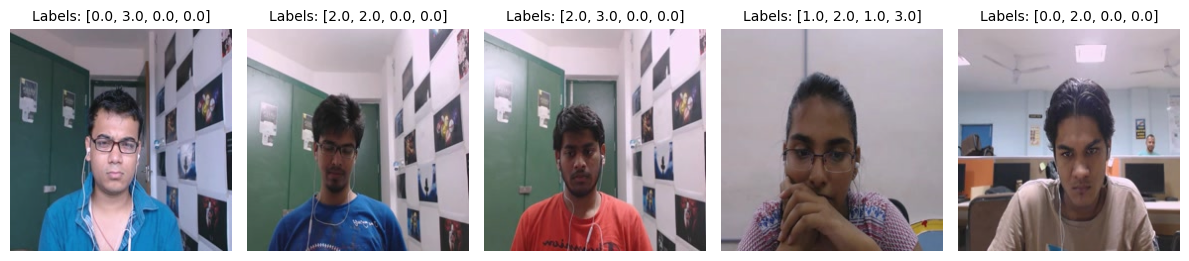

In [14]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def display_samples(data_loader, n_samples=5):
    """Display a grid of sample images with engagement labels."""
    try:
        images, labels = next(iter(data_loader))  # Get a batch
    except StopIteration:
        print("No data to display.")
        return
    
    # Inverse Transform to Convert Images Back to Displayable Format
    inv_trans = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                             std=[1/0.229, 1/0.224, 1/0.225]),
    ])
    
    plt.figure(figsize=(12, 4))
    for i in range(min(n_samples, len(images))):
        img = inv_trans(images[i])  # Reverse normalization
        img = img.permute(1, 2, 0).clamp(0, 1)  # Convert [C, H, W] → [H, W, C]
        
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(img.numpy())  # Convert to NumPy format for Matplotlib
        plt.title(f"Labels: {labels[i].tolist()}", fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Display sample images from the training set using the "Train" loader defined earlier
display_samples(loaders["Train"], n_samples=5)


### **Save preprocessed data**


In [15]:
import os
import torch

# Uncomment the lines below if you want to save the datasets for later use.
torch.save(datasets["Train"], os.path.join(str(FRAMES_ROOT), "train_set.pth"))
torch.save(datasets["Validation"], os.path.join(str(FRAMES_ROOT), "val_set.pth"))
torch.save(datasets["Test"], os.path.join(str(FRAMES_ROOT), "test_set.pth"))
